In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,IN0065000288,0,2018-11-02 10:47:06.200,4307,Dr chaminda bandara,Uva Province,Badulla,Badulla�,102,Lakshman Jayantha,13,Prabaharan Agencies,257,Unimelo Tab 7.5mg-100's,10.0,658.0,750.0,0.0,0.0,6580.0,2018,November,11,2,6,Friday,10
1,IN0065000288,0,2018-11-02 10:47:06.200,4307,Dr chaminda bandara,Uva Province,Badulla,Badulla�,102,Lakshman Jayantha,13,Prabaharan Agencies,257,Unimelo Tab 7.5mg-100's,0.0,658.0,750.0,1.0,1.0,0.0,2018,November,11,2,6,Friday,10
2,CSO009101067,113,2018-11-02 14:41:39.210,1713,Tharindu Pharmacy,Southern Province,Galle,Hikkaduwa,91,Sasanga Nawod,8,Kalyani Pharmacy,207,Growee Syrup 120ml,2.0,653.5,745.0,0.0,0.0,1307.0,2018,November,11,2,6,Friday,14
3,CSO011600701,114,2018-11-02 15:06:44.190,3073,Lanka Pharmacy (PVT) LTD,Western Province,Gampaha,Kiribathgoda,116,,22,Lucky Impex,206,Solmux Forte Susp. 60ml,10.0,412.3,470.0,0.0,0.0,4123.0,2018,November,11,2,6,Friday,15
4,CSO011701390,54,2018-11-02 16:00:03.777,366,THE BRITISH STORES,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,5,Pernex Ac 2.5 PCT Gel 20gm,1.0,405.4,462.0,0.0,0.0,405.4,2018,November,11,2,6,Friday,16


### Select the most selling product to identify the time series prediction

In [6]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Sec_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [7]:
Sec_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
85,CSO009201197,110,2018-11-02 16:47:22.857,1717,Delmon Pharmacy,Southern Province,Galle,Baddegama,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,16
86,CSO009201197,110,2018-11-02 16:47:22.857,1717,Delmon Pharmacy,Southern Province,Galle,Baddegama,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,2,6,Friday,16
180,CSO009201212,110,2018-11-05 12:10:37.477,1682,Kurundugaha Medical,Southern Province,Galle,Karandeniya,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,5,2,Monday,12
181,CSO009201212,110,2018-11-05 12:10:37.477,1682,Kurundugaha Medical,Southern Province,Galle,Karandeniya,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,5,2,Monday,12
202,CSO009400267,107,2018-11-03 13:02:57.117,662,Samarasinghe Pharmacy,Western Province,Colombo,Maharagama,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,15.0,238.7,272.0,0.0,0.0,3580.5,2018,November,11,3,7,Saturday,13


In [8]:
#Aggregate data into weekly sum
sample=Sec_invoice_All[['Date','UnitQty']]
weekly=sample.resample('W', on='Date').sum()

In [9]:
weekly

,UnitQty
Date,
2018-11-04,307.0
2018-11-11,7505.0
2018-11-18,5488.0
2018-11-25,5944.0
2018-12-02,18655.0
...,...
2020-02-02,11494.0
2020-02-09,1554.0
2020-02-16,6313.0


In [10]:
weekly = weekly.reset_index()

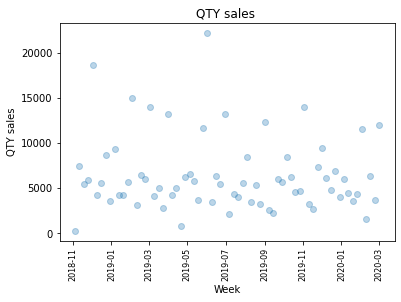

In [11]:
plt.scatter(weekly.Date , weekly.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

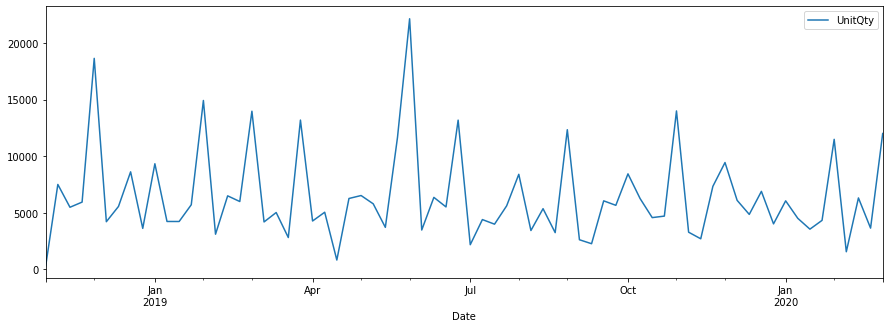

In [12]:
weekly.plot(kind = 'line', x = 'Date', y = 'UnitQty')
plt.show()

In [13]:
# remove z score > 3 
Sec_invoice_All = weekly[(np.abs(stats.zscore(weekly["UnitQty"])) < 3)]

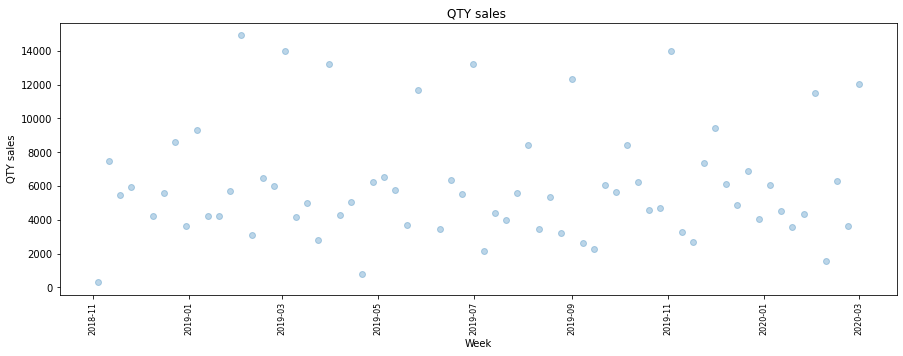

In [14]:
plt.scatter(Sec_invoice_All.Date , Sec_invoice_All.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

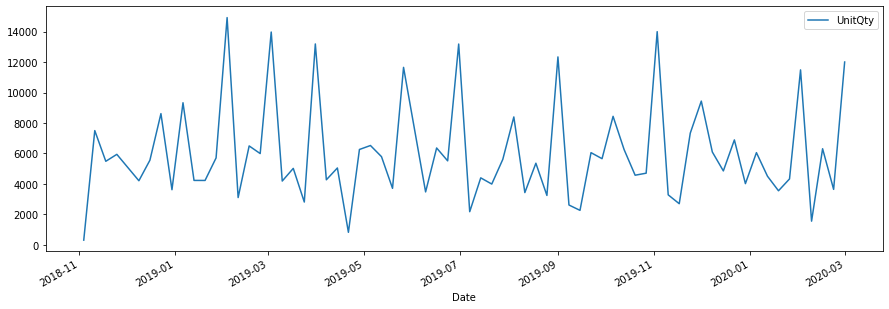

In [15]:
Sec_invoice_All.plot(kind = 'line', x = 'Date', y = 'UnitQty')
plt.show()

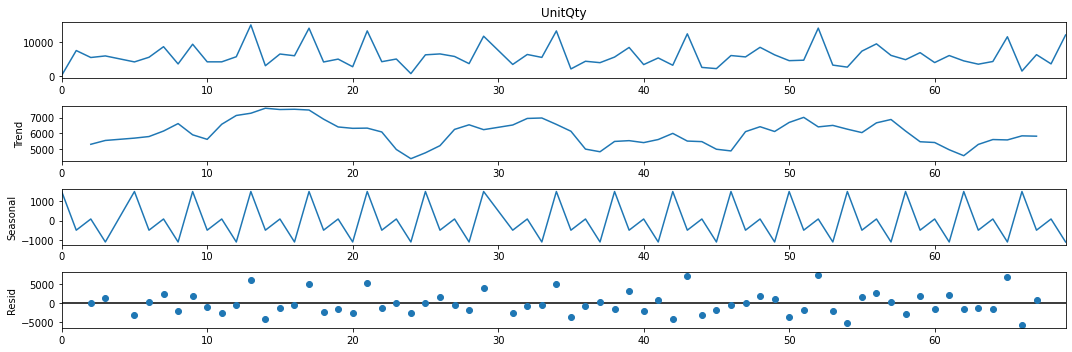

In [16]:
decomposition = seasonal_decompose(Sec_invoice_All['UnitQty'], period =4)
decomposition.plot()
plt.show()

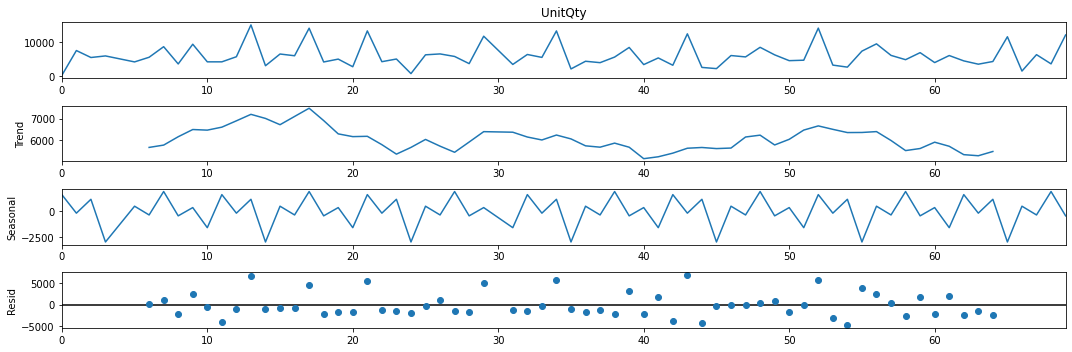

In [17]:
decomposition = seasonal_decompose(Sec_invoice_All['UnitQty'], period =10)
decomposition.plot()
plt.show()

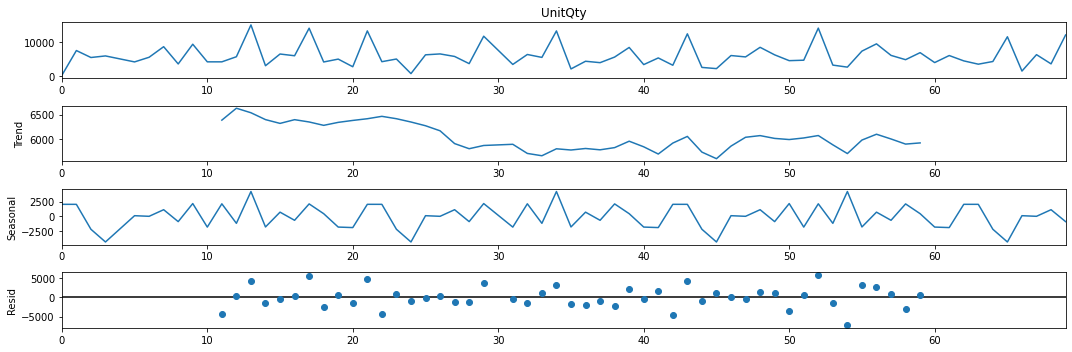

In [18]:
decomposition = seasonal_decompose(Sec_invoice_All['UnitQty'], period =20)
decomposition.plot()
plt.show()

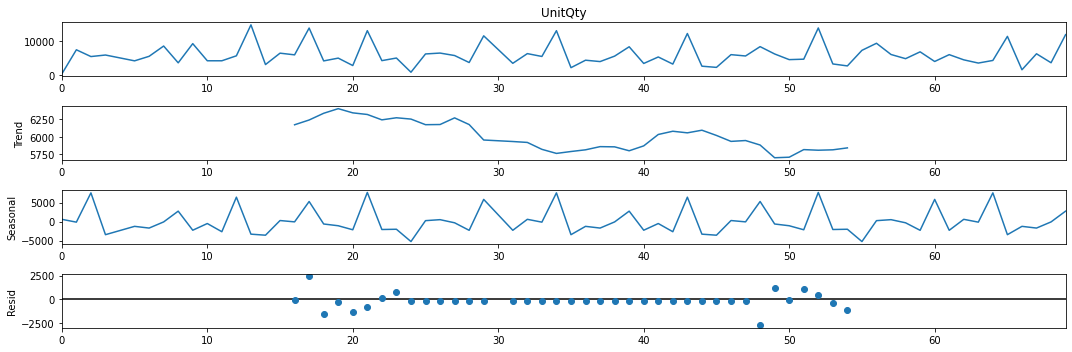

In [19]:
decomposition = seasonal_decompose(Sec_invoice_All['UnitQty'], period =30)
decomposition.plot()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Sec_invoice_All['UnitQty'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -3.620242
p-value                         0.005386
#Lags Used                      7.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [21]:
#create Date Table
def create_date_table2(start='2018-11-04', end='2020-03-01'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    return df

In [22]:
date_table = create_date_table2()

In [23]:
date_table.head(12)

,Date
0,2018-11-04
1,2018-11-05
2,2018-11-06
3,2018-11-07
4,2018-11-08
5,2018-11-09
6,2018-11-10
7,2018-11-11
8,2018-11-12
9,2018-11-13


In [24]:
# keep every 7th row
date_table = date_table.iloc[::7, :]

In [25]:
date_table

,Date
0,2018-11-04
7,2018-11-11
14,2018-11-18
21,2018-11-25
28,2018-12-02
...,...
455,2020-02-02
462,2020-02-09
469,2020-02-16
476,2020-02-23


In [26]:
#left Join with Weekly date table
Sec_inv_mis = date_table.merge(Sec_invoice_All, on='Date', how='left')

In [27]:
Sec_inv_mis.head(10)

,Date,UnitQty
0,2018-11-04,307.0
1,2018-11-11,7505.0
2,2018-11-18,5488.0
3,2018-11-25,5944.0
4,2018-12-02,NaN
5,2018-12-09,4210.0
6,2018-12-16,5559.0
7,2018-12-23,8620.0
8,2018-12-30,3620.0
9,2019-01-06,9335.0


In [28]:
#fill missing value with mean
Sec_inv_mis.fillna({"UnitQty":Sec_inv_mis['UnitQty'].mean().round(1)}, inplace=True)

In [29]:
Sec_inv_grp = Sec_inv_mis.sort_index()
Sec_inv_grp.head(10)

,Date,UnitQty
0,2018-11-04,307.0
1,2018-11-11,7505.0
2,2018-11-18,5488.0
3,2018-11-25,5944.0
4,2018-12-02,6011.2
5,2018-12-09,4210.0
6,2018-12-16,5559.0
7,2018-12-23,8620.0
8,2018-12-30,3620.0
9,2019-01-06,9335.0


In [30]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Sec_inv_grp.loc[Sec_inv_grp['Date'] <= "2019-11-30"]
train = train.set_index('Date')
test = Sec_inv_grp.loc[Sec_inv_grp['Date'] > "2019-11-30"]
test = test.set_index('Date')

In [33]:
from pmdarima import auto_arima
model = auto_arima(train.UnitQty, test='adf', trace=True)
results = model.fit(train.UnitQty)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1061.989, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1070.771, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1067.162, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1063.399, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1150.178, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1065.709, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1070.892, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1059.094, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1059.874, Time=0.06 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1058.812, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1060.498, Time=0.12 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=1060.811, Time=0.21 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1060.612, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1058.958, Time=0.15 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(4, 0, 2)   Log Likelihood                -521.406
Date:                Sat, 16 Apr 2022   AIC                           1058.812
Time:                        16:28:41   BIC                           1075.015
Sample:                             0   HQIC                          1065.094
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8532.3635   6190.965      1.378      0.168   -3601.705    2.07e+04
ar.L1          0.0345      0.382      0.090      0.928      -0.715       0.784
ar.L2         -0.4490      0.333     -1.350      0.177      -1.101       0.203
ar.L3         -0.2668      0.283     -0.943      0.345      -0.821       0.288
ar.L4          0.2724      0.220      1.238      0.216      -0.159       0.703
ma.L1         -0.5083      0.361     -1.409      0.159      -1.215       0.199
ma.L2          0.4510      0.287      1.570      0.116      -0.112       1.014
sigma2      7.552e+06      1.034    7.3e+06      0.000    7.55e+06    7.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.30
Prob(Q):                              0.96   Prob(JB):                         0.07
Heteroskedasticity (H):               0.87   Skew:                             0.73
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.93e+23. Standard errors may be unstable.
"""

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['UnitQty'],
                order=(4,0,1),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                UnitQty   No. Observations:                   56
Model:               SARIMAX(4, 0, 1)   Log Likelihood                -527.572
Date:                Sat, 16 Apr 2022   AIC                           1067.144
Time:                        16:28:59   BIC                           1079.296
Sample:                    11-04-2018   HQIC                          1071.855
                         - 11-24-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3401      0.184      1.849      0.064      -0.020       0.701
ar.L2          0.0656      0.178      0.368      0.713      -0.284       0.415
ar.L3          0.0363      0.162      0.224      0.823      -0.281       0.354
ar.L4          0.5529      0.110      5.009      0.000       0.337       0.769
ma.L1         -0.6492      0.176     -3.680      0.000      -0.995      -0.303
sigma2      8.206e+06   2.85e-09   2.88e+15      0.000    8.21e+06    8.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.97   Prob(JB):                         0.27
Heteroskedasticity (H):               1.08   Skew:                             0.53
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.02e+31. Standard errors may be unstable.
"""

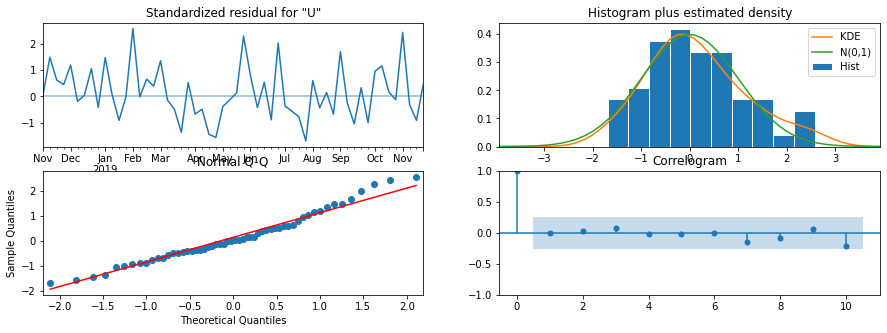

In [35]:
results.plot_diagnostics()
plt.show()

### Rolling Forecast ARIMA Model

In [38]:
X = Sec_inv_grp.UnitQty.values
data_Size = int(len(Sec_inv_grp.UnitQty.values))
train_size = int(len(train.UnitQty.values))


X_train, X_test = X[0:train_size], X[train_size:data_Size]
history = [x for x in X_train]
predictions = []

In [39]:
for t in range(len(test)):
    model = SARIMAX(history, order=(4,0,1),seasonal_order=(0,0,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [40]:
# get array data to DF with date index
Prd_Results = pd.DataFrame(data = predictions, columns = ['UnitQty'], index = test.index.copy())

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test, Prd_Results)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 2467.102977


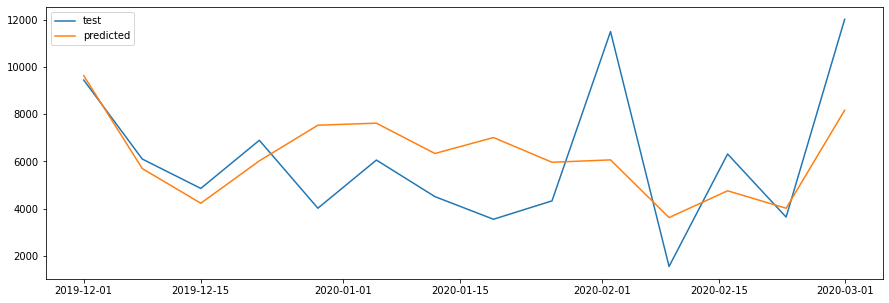

In [42]:
plt.plot(test)
plt.plot(Prd_Results)
plt.legend(['test', 'predicted'])